In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 5개 영상만 사용해 MTCNN 모델 활용 - 얼굴 추출 및 시각화

In [2]:
!pip install facenet_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.

In [12]:
from facenet_pytorch import MTCNN
import torch
import cv2
import matplotlib.pyplot as plt
import os

In [22]:
# MTCNN 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(keep_all=True, device=device)


# 장치 정보 출력
print(f"Using device: {device}")

Using device: cuda


In [27]:
# 3. 5개의 영상 파일 경로 설정
video_paths = [
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_aagfhgtpmv.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_aapnvogymq.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abarnvbtwb.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abofeumbvv.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abqwwspghj.mp4'
]

# 각 비디오 파일 경로 존재 여부 확인
for video_path in video_paths:
    if os.path.exists(video_path):
        print(f"{video_path} 존재")
    else:
        print(f"{video_path} 존재 안함. 경로 다시 체크 필요")

/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_aagfhgtpmv.mp4 존재
/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_aapnvogymq.mp4 존재
/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abarnvbtwb.mp4 존재
/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abofeumbvv.mp4 존재
/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abqwwspghj.mp4 존재


1. video_paths : 비디오 리스트
2. cap : openCV 함수 비디오 파일 읽는 개체
3. frame_rate : 비디오 초당 프레임 수
(재생속도)
4. total_frames : 비디오의 전체 프레임 수 반환
5. frame_interval : 프레임 추출하는 간격 - 10 프레임
6. max_frames : 얼굴 검출 최대 프레임 수 (최대 32까지)
7. detected_face : 검출된 얼굴 저장 - 리스트
8. frame_count : 현재 읽은 프레임 수 추척 (10프레임마다 한번씩)
9. extracted_frame_count : 실제 얼굴 검출 수행한 프레임 (max_frames넘으면 중단)
10 ret : 프레임을 정상적으로 읽었는지 값(false - 중단)
11. frame : 실제 비디오 프레임 이미지 - 얼굴검출에 사용
12. frb_frame : rgb형식으로 변환한 값
13. faces : 얼굴 검출 함수

## 파일 및 경로 테스트

In [28]:
# 첫 번째 비디오 파일만 테스트로 열어 확인

video_path = video_paths[0]
cap = cv2.VideoCapture(video_path)

if cap.isOpened():
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video '{video_path}' opened successfully.")
    print(f"Frame rate: {frame_rate}, Total frames: {total_frames}")
else:
    print(f"Failed to open video '{video_path}'.")
cap.release()

Video '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_aagfhgtpmv.mp4' opened successfully.
Frame rate: 29, Total frames: 300


In [29]:
# 프레임을 하나 추출, rgb로 변환 후 변환된 프레임 크기 확인하기

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if ret:
    # 프레임을 RGB로 변환
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print(f"Extracted frame shape: {rgb_frame.shape}")  # 예상 결과: (height, width, 3)
else:
    print("Failed to read the frame.")
cap.release()

Extracted frame shape: (1080, 1920, 3)


In [30]:
# 얼굴 검출 수행 / 확인
# 몇개의 얼굴이 검출되었나?

faces = mtcnn(rgb_frame)
if faces is not None:
    print(f"Faces detected: {len(faces)}")
else:
    print("No faces detected.")

Faces detected: 1


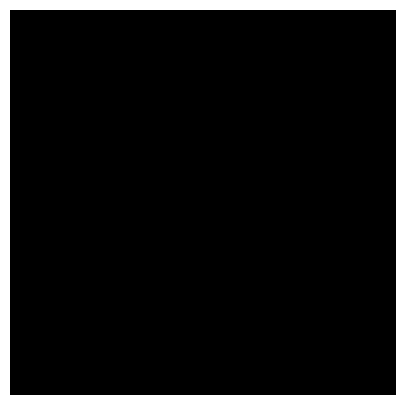

Save path exists: True


In [33]:
if faces is not None and len(faces) > 0:
    plt.figure(figsize=(10, 5))
    for i, face in enumerate(faces[:5]):  # 최대 5개만 시각화
        plt.subplot(1, len(faces[:5]), i + 1)
        plt.imshow(face.permute(1, 2, 0).int())
        plt.axis('off')
    plt.show()

    # 저장 경로 설정 및 확인
    save_path = '/content/drive/MyDrive/OSSW/dfdc_mtenn/mini_data/saved_face/'
    os.makedirs(save_path, exist_ok=True)
    print(f"Save path exists: {os.path.exists(save_path)}")
else:
    print("No faces detected to display.")

In [ ]:
# 아직하지마
# 4. 각 영상에서 얼굴 검출 및 시각화


for i, video_path in enumerate(video_paths):
    cap = cv2.VideoCapture(video_path)
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))  # 영상의 초당 프레임 수
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # 전체 프레임 수

    frame_interval = 5  # 5개 프레임마다 한 프레임 추출
    max_frames = min(32, total_frames // frame_interval)  # 최대 32개 프레임 추출

    detected_faces = []
    frame_count = 0
    extracted_frame_count = 0

    while cap.isOpened() and extracted_frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        # 10개 프레임마다 1개 프레임 추출
        if frame_count % frame_interval == 0:
            print(f"Processing frame {frame_count}...")  # 현재 처리 중인 프레임 출력

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # 프레임을 RGB로 변환

            # RGB 변환 후 shape 확인
            print(f"RGB frame shape: {rgb_frame.shape}")  # (height, width, channels) 확인

            faces = mtcnn(rgb_frame)  # 얼굴 검출
            extracted_frame_count += 1

            if faces is not None:
                print(f"Faces detected in frame {frame_count}: {len(faces)} faces")  # 얼굴 개수 출력
                for face in faces:
                    detected_faces.append(face)
                else:
                    print(f"No faces detected in frame {frame_count}")  # 얼굴 검출 안됨

        frame_count += 1

    cap.release()  # 비디오 캡처 객체 닫기

    # 시각화
    if detected_faces:
        plt.figure(figsize=(20, 5))
        for j, face in enumerate(detected_faces[:5]):  # 최대 5개의 얼굴만 시각화
            plt.subplot(1, len(detected_faces[:5]), j + 1)
            plt.imshow(face.permute(1, 2, 0).int())
            plt.axis('off')
            plt.suptitle(f'Faces detected from video_{i + 1}.mp4')

            # 저장할 폴더 경로
            save_path = f'/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/saved_face/'
            # 이미지 파일로 저장
            save_filename = f'{save_path}face_{j + 1}.png'
            plt.savefig(save_filename, bbox_inches='tight')
            plt.close()  # 그래프 닫기
    else:
        print(f"No faces detected in video_{i + 1}.mp4")

## 5개영상 얼굴 검출, 이미지 파일 저장

In [36]:
# 비디오 파일 경로 리스트
video_paths = [
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_aagfhgtpmv.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_aapnvogymq.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abarnvbtwb.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abofeumbvv.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abqwwspghj.mp4'
]

# 얼굴 검출 및 저장 경로 설정
save_path = '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/saved_face/'
os.makedirs(save_path, exist_ok=True)

# 각 비디오에서 얼굴 검출 및 저장
for i, video_path in enumerate(video_paths):
    cap = cv2.VideoCapture(video_path)
    frame_interval = 10  # 10 프레임마다 얼굴 검출
    max_frames = 32      # 최대 32개 프레임에서 얼굴 검출
    detected_faces = []   # 검출된 얼굴을 저장할 리스트
    frame_count = 0
    extracted_frame_count = 0

    while cap.isOpened() and extracted_frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        # 설정한 간격에 맞춰 프레임 추출
        if frame_count % frame_interval == 0:
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = mtcnn(rgb_frame)  # 얼굴 검출 수행
            extracted_frame_count += 1

            # 얼굴이 검출되었을 때 리스트에 추가
            if faces is not None and len(faces) > 0:
                detected_faces.extend(faces)

        frame_count += 1
    cap.release()

    # 검출된 얼굴이 있을 경우 최대 5개까지 저장
    if detected_faces:
        for j, face in enumerate(detected_faces[:5]):  # 최대 5개만 저장
            # 이미지 파일 경로 및 이름 설정
            save_filename = os.path.join(save_path, f'video_{i+1}_face_{j+1}.png')
            plt.imshow(face.permute(1, 2, 0).int())
            plt.axis('off')
            plt.savefig(save_filename, bbox_inches='tight')
            plt.close()
        print(f"Faces from video_{i+1} saved successfully.")
    else:
        print(f"No faces detected in video_{i + 1}.mp4")

Faces from video_1 saved successfully.
Faces from video_2 saved successfully.
Faces from video_3 saved successfully.
Faces from video_4 saved successfully.
Faces from video_5 saved successfully.


In [41]:
# 비디오 파일 경로 리스트
video_paths = [
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_aagfhgtpmv.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_aapnvogymq.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abarnvbtwb.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abofeumbvv.mp4',
    '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/train_minidata/mini_abqwwspghj.mp4'
]

# 얼굴 검출 및 저장 경로 설정
save_path = '/content/drive/MyDrive/OSSW/dfdc_mtcnn/mini_data/saved_face/'

# 저장 경로가 존재하는지 확인하고, 없으면 생성합니다.
os.makedirs(save_path, exist_ok=True)

# 각 비디오에서 얼굴 검출 및 저장
for i, video_path in enumerate(video_paths):
    cap = cv2.VideoCapture(video_path)
    frame_interval = 10  # 10 프레임마다 얼굴 검출
    max_frames = 32      # 최대 32개 프레임에서 얼굴 검출
    detected_faces = []   # 검출된 얼굴을 저장할 리스트
    frame_count = 0
    extracted_frame_count = 0

    while cap.isOpened() and extracted_frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        # 설정한 간격에 맞춰 프레임 추출
        if frame_count % frame_interval == 0:
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = mtcnn(rgb_frame)  # 얼굴 검출 수행
            extracted_frame_count += 1

            # 얼굴이 검출되었을 때 리스트에 추가
            if faces is not None and len(faces) > 0:
                detected_faces.extend(faces)

        frame_count += 1
    cap.release()

    # 검출된 얼굴이 있을 경우 최대 5개까지 저장
    if detected_faces:
        for j, face in enumerate(detected_faces[:5]):  # 최대 5개만 저장
            # face 텐서를 [0, 255] 범위의 uint8 형식으로 변환
            face_img = (face.permute(1, 2, 0).clamp(0, 1) * 255).byte().cpu().numpy()

            # 이미지 파일 경로 및 이름 설정
            save_filename = os.path.join(save_path, f'video_{i+1}_face_{j+1}.png')
            # 저장 경로가 존재하는지 다시 한번 확인합니다.
            os.makedirs(os.path.dirname(save_filename), exist_ok=True)
            plt.imsave(save_filename, face_img)
            print(f"Faces from video_{i+1} saved successfully.")
    else:
        print(f"No faces detected in video_{i + 1}.mp4")


Faces from video_1 saved successfully.
Faces from video_1 saved successfully.
Faces from video_1 saved successfully.
Faces from video_1 saved successfully.
Faces from video_1 saved successfully.
Faces from video_2 saved successfully.
Faces from video_2 saved successfully.
Faces from video_2 saved successfully.
Faces from video_2 saved successfully.
Faces from video_2 saved successfully.
Faces from video_3 saved successfully.
Faces from video_3 saved successfully.
Faces from video_3 saved successfully.
Faces from video_3 saved successfully.
Faces from video_3 saved successfully.
Faces from video_4 saved successfully.
Faces from video_4 saved successfully.
Faces from video_4 saved successfully.
Faces from video_4 saved successfully.
Faces from video_4 saved successfully.
Faces from video_5 saved successfully.
Faces from video_5 saved successfully.
Faces from video_5 saved successfully.
Faces from video_5 saved successfully.
Faces from video_5 saved successfully.
